Code framework and lessons from: https://course.fast.ai/Lessons/lesson1.html 


Data:
@article{islam2022aweb,
  title={A Web-scraped Skin Image Database of Monkeypox, Chickenpox, Smallpox, Cowpox, and Measles},
  author={Islam, Towhidul and Hussain, Mohammad Arafat and Chowdhury, Forhad Uddin Hasan and Islam, B M Riazul},
  journal={bioRxiv 2022.08.01.502199},
  doi={https://doi.org/10.1101/2022.08.01.502199},
  year={2022}
}

# Install Fast AI Library

In [3]:
!pip install -Uqq fastai

# Import Libraries

In [3]:
from fastai.vision.all import *

# 1. Create Datablock from Preprocessed Images to Tweak Hyperparameters from

In [4]:
folder = "../input/monkeypox-skin-image-dataset-2022/preprocessed_original_images/preprocessed_original_images/"
path = Path(folder)

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

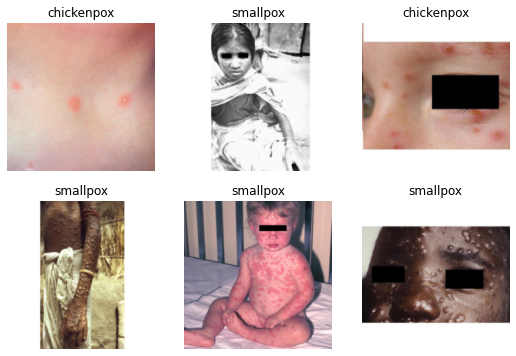

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

# 2. Train Model on Preprocessed Images

First model, transfer learning with resnet50 on preprocessed images to get an idea of initial error rates and confusion

In [40]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.358721,0.184990,0.066887,03:46


epoch,train_loss,valid_loss,error_rate,time
0,0.100351,0.070076,0.020561,03:55
1,0.016672,0.012923,0.003808,03:57
2,0.003236,0.007486,0.001777,03:54


Accuracy is already pretty great... let's see how it performs on the augmented dataset:

# 3. Train Model on Augmented Images

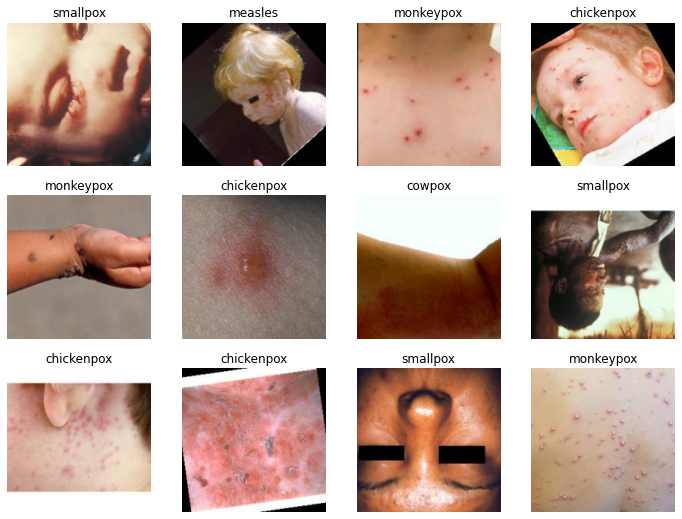

In [5]:
augmentedFolder = "../input/monkeypox-skin-image-dataset-2022/augmented_images/augmented_images"
augmentedPath = Path(augmentedFolder)

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(augmentedPath)

dls.show_batch(max_n=12)


In [6]:
learn2 = vision_learner(dls, resnet50, metrics=error_rate)
learn2.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.367451,0.199343,0.067775,05:27


epoch,train_loss,valid_loss,error_rate,time
0,0.100085,0.040526,0.014088,04:04
1,0.028682,0.012794,0.003935,04:06
2,0.005196,0.005769,0.002665,04:04


# 99.99% accuracy, thanks resnet50!

# 4. Visualize and Export Model

In [8]:
# https://forums.fast.ai/t/plotting-metrics-after-learning/69937/2 source for function below
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

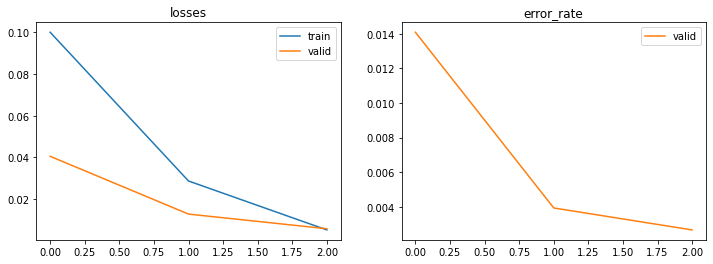

In [9]:
learn2.recorder.plot_metrics()

In [10]:
interp = ClassificationInterpretation.from_learner(learn2)

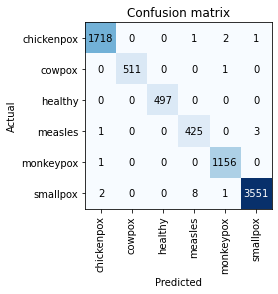

In [11]:
fig = interp.plot_confusion_matrix()
fig

In [12]:
interp.most_confused()

[('smallpox', 'measles', 8),
 ('measles', 'smallpox', 3),
 ('chickenpox', 'monkeypox', 2),
 ('smallpox', 'chickenpox', 2),
 ('chickenpox', 'measles', 1),
 ('chickenpox', 'smallpox', 1),
 ('cowpox', 'monkeypox', 1),
 ('measles', 'chickenpox', 1),
 ('monkeypox', 'chickenpox', 1),
 ('smallpox', 'monkeypox', 1)]

Above is the typical mistakes being made, notably only 5 mistakes involvling monkeypox!

# 5. Export model!

In [13]:
learn2.export("model.pkl")